# Work in progress

In [83]:
import c2qa
import numpy as np
from qiskit import ClassicalRegister, visualization, AncillaRegister
from qiskit.quantum_info.operators.predicates import is_unitary_matrix
from math import pi

# Error Correction with the Binomial 'Kitten' Code

In the context of bosonic systems, photon loss is a significant source of errors. The binomial 'kitten' code is a quantum error correction code designed to protect against such errors by encoding logical qubit information into bosonic qumodes.

This photon loss error occurs when photons 'leak' out of the system, leading to a loss of quantum information. The rate of photon loss is typically proportional to the number of photons in the system. 

Binomial codes are a family of quantum error-correcting codes that are particularly well-suited for correcting photon loss errors. They encode logical qubits into superpositions of Fock states (states with a defined number of photons). The simplest binomial code is the 'kitten' code, which can detect and correct single-photon loss errors. Multiple errors will result in a logical error.

In the 'kitten' code, the logical qubit states are defined as superpositions of Fock states with specific properties. For the 'kitten' code, the logical states are:

\begin{align*}
|0_L\rangle &= \frac{1}{\sqrt{2}} (|0\rangle + |4\rangle) \\
|1_L\rangle &= |2\rangle \\
\end{align*}

These states have several important properties:
 - **Photon Number Parity**: Both logical states have even photon number parity. This means that single-photon loss errors, which change the photon number by one, will map these states onto odd parity Fock states.
 - **Error Detection**: By measuring the photon number parity (whether the photon number is even or odd), we can detect the occurrence of a single-photon loss error without collapsing the logical state.
 - **Logical Information Protection**: The logical information is distributed across multiple Fock states, providing redundancy that helps protect against errors.

For a more in depth explanation on the maths used in the binomial kitten code visit the [official bosonic kitten code example](https://github.com/C2QA/bosonic-qiskit/blob/main/tutorials/bosonic-kitten-code/bosonic-kitten-code.ipynb).

<br> <br>

## Implementing Photon Loss

We use the class PhotonLossNoisePass() to simulate photon loss error during the execution of our quantum circuit. We can choose a photon loss rate and will go with a rate of 0.5 per millisecond. This corresponds to a lifetime of 2 ms, which is the average amount of time a photon will “survive” in the qumode. To see photon loss in action we need to delay our circuit so the error has a higher change to occur. By applying a delay of 1 ms the effects of photon loss will be clearly evident. 

To show the effects we will initialise the circuit in Fock state |7⟩. This is the highest Fock state in a system with 3 qubits per qumode (23=8, starting at |0⟩). The circuit will look as follows: 

![Photon loss circuit](images/PhotonNoiceLossCircuit.png)

The array in the initialisation gate means the first 7 states ($|0\rangle-|6\rangle$) have a 0% change of existing and the $|7\rangle$ state a 100% change. After the delay the final state is measured into three classical bits.

/Users/benjamin/Code Projects/HvA/exploring-bosonic-qiskit-qec/c2qa/kraus.py:185: UserWarning: PhotonLossNoisePass ignores instructions without duration, you may need to schedule circuit in advance.
  warnings.warn(


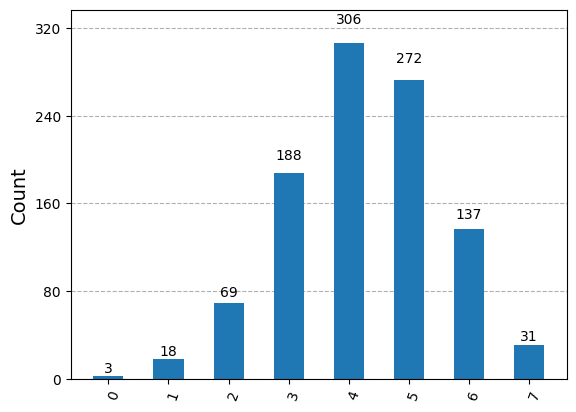

In [2]:
num_qumodes = 1
num_qubits_per_qumode = 3

photon_loss_rate = 0.5 # loss rate in units of 1/ms
circuit_delay = 1 # large enough for on average 2 photons to be lost
time_unit = "ms"

qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
cr = ClassicalRegister(num_qumodes * num_qubits_per_qumode)
circuit = c2qa.CVCircuit(qmr, cr)

# to illustrate photon loss, initialise the qumode in Fock state |7>
circuit.cv_initialize(7, qmr[0])

# apply a delay to illustrate the effect of photon loss
circuit.cv_delay(duration=circuit_delay, unit=time_unit, qumode=qmr[0])

noise_pass = c2qa.kraus.PhotonLossNoisePass(photon_loss_rates=photon_loss_rate, circuit=circuit, time_unit=time_unit)

circuit.cv_measure(qmr[0], cr)

# circuit.draw('mpl')

counts = c2qa.util.simulate(circuit, noise_passes=noise_pass)[2] # Returns a tuple of state, result, fock_counts

visualization.plot_histogram(counts)

As expected after 1024 simulation shots (default for `util.simulate()`) we see a distribution of Fock states (photon numbers).

<br> <br>

# Error Detection

In [3]:
# Create a new circuit with 1 qumode, 1 ancilla qubit, and 1 classical register for ancilla readout.
qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
anc = AncillaRegister(1)
cr = ClassicalRegister(1)
circuit = c2qa.CVCircuit(qmr, anc, cr)

circuit.initialize([1, 0], anc[0]) # Initialise ancilla qubit in |0> (even) state

# Initialise qumode in either odd parity or even parity Fock state
# circuit.cv_initialize(2, qmr) # |2> (even) Fock state
circuit.cv_initialize(3, qmr) # |3> (odd) Fock state

circuit.h(anc)

circuit.cv_c_r(pi/2, qmr[0], anc)
circuit.cv_r(-pi/2, qmr[0])

circuit.h(anc)
circuit.cv_measure(anc, cr)

counts = c2qa.util.simulate(circuit)[2]

# Measurement will return 0 for even parity and 1 for odd parity
print(counts)

{'1': 1024}


/Users/benjamin/Code Projects/HvA/exploring-bosonic-qiskit-qec/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


### bla

In [4]:
empty = np.zeros((2**num_qubits_per_qumode, 2**num_qubits_per_qumode))

# map logical |1> photon loss (fock state |1>) back to logical state |1>. (where fock_input = |1>, and fock_output = |2>)
u_odd = c2qa.util.fockmap(matrix=empty, fock_input=[1], fock_output=[2])

# map logical |0> photon loss (fock state |3>) back to logical state |0> ((|0> + |4>)/sqrt(2))
u_odd = c2qa.util.fockmap(matrix=u_odd, fock_input=[3, 3], fock_output=[0, 4], amplitude=[1/np.sqrt(2), 1/np.sqrt(2)]) 

# satisfy unitary condition
u_odd = c2qa.util.fockmap(u_odd, [5, 6, 7], [5, 6, 7])
u_odd = c2qa.util.fockmap(u_odd, [2, 0], [3, 1])
u_odd = c2qa.util.fockmap(u_odd, [4, 4], [0, 4], 1/np.sqrt(2) * np.array([1, -1]))

assert(is_unitary_matrix(u_odd))

def u_even(kt):
    # map logical |1> photon loss (fock state |2>) back to logical state |1>
    u_even = c2qa.util.fockmap(matrix=empty, fock_input=[2], fock_output=[2])

    # map logical |0> photon loss (fock state |0> or |4>) back to logical state |0> 
    # (fock_input = |0>, fock_output = (|0> + |4>) * amplitude. fock_input = |4>, fock_output = (|0> + |4>) * amplitude)
    u_even = c2qa.util.fockmap(matrix=u_even, fock_input=[0, 0, 4, 4], fock_output=[0, 4, 0, 4], amplitude=(1/np.sqrt(1 + kt**2) * np.array([1, kt, -kt, 1])))

    # satisfy unitary condition
    u_even = c2qa.util.fockmap(u_even, [1, 3, 5, 6, 7], [1, 3, 5, 6, 7]) 

    assert(is_unitary_matrix(u_even))
    return u_even

### bla

In [5]:
qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
cr = ClassicalRegister(num_qumodes * num_qubits_per_qumode)
circuit = c2qa.CVCircuit(qmr, cr)

# initialise qumode in |1_L> error state (|1>)
circuit.cv_initialize([0, 1], qmr) # (0 * |0> + 1 * |1>) = |1>

# append the u_odd matrix to circuit and measure
circuit.cv_gate_from_matrix(u_odd, qmr[0])
circuit.cv_measure(qmr[0], cr)

counts = c2qa.util.simulate(circuit)[2]

# We measure |2> Fock state, demonstrating recovery of the logical |1> state
print(counts)

{'2': 1024}


# -this-

/Users/benjamin/Code Projects/HvA/exploring-bosonic-qiskit-qec/c2qa/kraus.py:185: UserWarning: PhotonLossNoisePass ignores instructions without duration, you may need to schedule circuit in advance.
  warnings.warn(
/Users/benjamin/Code Projects/HvA/exploring-bosonic-qiskit-qec/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


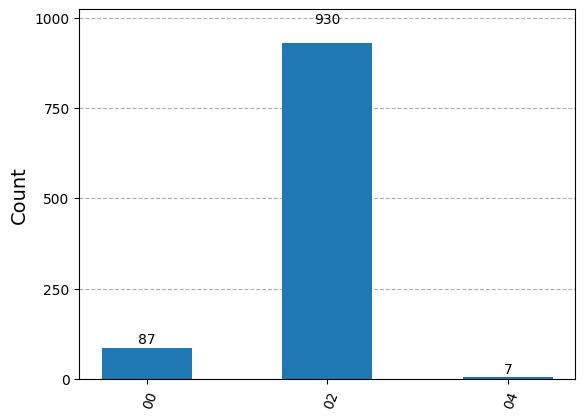

In [82]:
num_qumodes = 1
num_qubits_per_qumode = 3

photon_loss_rate = 0.75 # loss rate in units of 1/ms
circuit_delay = 0.5
time_unit = "ms"

# create circuit
qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
anc = AncillaRegister(1)
cr = ClassicalRegister(num_qumodes * num_qubits_per_qumode + 1)
circuit = c2qa.CVCircuit(qmr, anc, cr)


def do_error_correction(circuit):
    # photon parity measurement
    circuit.h(anc[0])
    circuit.cv_c_r(pi/2, qmr[0], anc[0])
    
    circuit.cv_r(-pi/2, qmr[0])
    
    circuit.h(anc[0])
    circuit.measure(anc[0], cr[0])
            
    kt_dur = circuit_delay # time since previous error correction
    kt = photon_loss_rate * (kt_dur + 0.01)
            
    with circuit.if_test((cr[0], 1), label='Recovery operator') as else_:
        circuit.cv_gate_from_matrix(u_odd, qmr[0], duration=0.1, unit="ns")
        circuit.reset(anc[0])
    with else_:
        circuit.cv_gate_from_matrix(u_even(kt), qmr[0], duration=0.1, unit="ns")
    

# initialise ancilla qubit in even |0> or odd |1> state
circuit.initialize(0, anc[0]) 
# initialise qumode in Fock state
circuit.cv_initialize(2, qmr[0])

# apply a delay to illustrate the effect of photon loss
circuit.cv_delay(duration=circuit_delay, unit=time_unit, qumode=qmr[0])

# apply error correction
do_error_correction(circuit)

noise_pass = c2qa.kraus.PhotonLossNoisePass(photon_loss_rates=photon_loss_rate, circuit=circuit, time_unit=time_unit)

# to see the loss and correction, add measurements and count up the results
circuit.cv_measure(qmr[0], cr)

# circuit.draw('mpl')

counts = c2qa.util.simulate(circuit, noise_passes=noise_pass)[2] # returns a tuple of state, result, fock_counts

visualization.plot_histogram(counts)